<h3>Importing Libraries</h3>

In [43]:
# Importing Libraries
from keras.backend.tensorflow_backend import set_session
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import TimeDistributed
from keras.layers import LSTM, Dropout
from keras import optimizers
import pandas as pd
import numpy as np
from datetime import datetime, date, timedelta
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import confusion_matrix, roc_curve, auc,accuracy_score
import matplotlib.pyplot as plt
from itertools import cycle
from keras.models import load_model
import itertools
import pickle

<h4>Importing Dataset</h4>

In [44]:
train_log= pd.read_csv('/Users/jyoti/OneDrive/DLFinal/Project2/norm.csv')

In [45]:
train_log.columns

Index(['enrollment_id', 'date', 'access', 'discussion', 'navigate',
       'page_close', 'problem', 'video', 'wiki', 'session', 'tot_time',
       'result'],
      dtype='object')

In [46]:
df1 = train_log["access"]

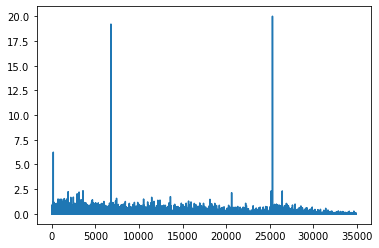

In [47]:
import matplotlib.pyplot as plt
plt.plot(df1)

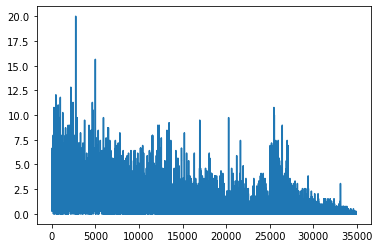

In [48]:
df2 = train_log["session"]
import matplotlib.pyplot as plt
plt.plot(df2)

In [49]:
train_num = 8000
test_num = 728

In [50]:
en_ids = train_log['enrollment_id'].unique()
print(en_ids.shape)

(8728,)


In [51]:
np.random.shuffle(en_ids)
en_ids

array([ 34644,  17413,  21973, ...,  30995, 107050,    208])

In [52]:
tr_en_ids = en_ids[:train_num]
ts_en_ids = en_ids[train_num:]

In [53]:
(train_log[train_log['enrollment_id'].isin(ts_en_ids)]['result'].values.sum()/4)/728

0.6717032967032966

In [54]:
(train_log[train_log['enrollment_id'].isin(tr_en_ids)]['result'].values.sum()/4)/8000

0.64475

In [55]:
tr_en_ids.shape

(8000,)

In [56]:
ts_en_ids.shape

(728,)

<h4>Datagen Creation</h4>

In [57]:
import random
def datagen(batchsize = 32, mode = 'train'):
    counter = 0
    x, y = [],[]
    while True:
        if mode == 'train':
            idx = random.choice(tr_en_ids)
        else:
            idx =random.choice(ts_en_ids)
        temp = train_log[train_log['enrollment_id']==idx]
        row = []
        for i in range(temp.shape[0]):
            row.append(temp.iloc[i].values[2:-1])
        x.append(row)
        y.append(temp.iloc[0].values[-1])
        
        counter+=1
        if counter==batchsize:
            yield np.array(x),np.array(y)
            counter = 0
            x, y = [], [] 

In [58]:
tr_dg  = datagen(mode='train')
ts_dg = datagen(mode = 'test', batchsize=32)

<h4>Model Architecture</h4>

In [59]:
# The LSTM architecture
from keras.optimizers import SGD
from keras.metrics import Precision, Recall
from keras import regularizers

model = Sequential()
# First LSTM layer with Dropout regularisation

model.add(LSTM((512), batch_input_shape=(32, 4,9),activation = "relu", kernel_initializer = "uniform", activity_regularizer = regularizers.l2(0.01), return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM((512), batch_input_shape=(32, 4,9),activation = "relu", kernel_initializer = "uniform", activity_regularizer = regularizers.l2(0.01), return_sequences=False))
model.add(Dropout(0.2))
#-----------------
model.add(Dropout(0.2))
#--------------------

model.add(Dropout(0.2))

model.add(Dropout(0.2))
#--------------------

# The output layer
model.add(Dense(1, activation='sigmoid'))

# Compiling the RNN

# model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
model.compile(loss='binary_crossentropy',optimizer = 'sgd', metrics=['accuracy', Precision(), Recall()])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (32, 4, 512)              1069056   
_________________________________________________________________
dropout_11 (Dropout)         (32, 4, 512)              0         
_________________________________________________________________
lstm_6 (LSTM)                (32, 512)                 2099200   
_________________________________________________________________
dropout_12 (Dropout)         (32, 512)                 0         
_________________________________________________________________
dropout_13 (Dropout)         (32, 512)                 0         
_________________________________________________________________
dropout_14 (Dropout)         (32, 512)                 0         
_________________________________________________________________
dropout_15 (Dropout)         (32, 512)                

<h4> Early Stopping and Check Points</h4>

In [60]:
# Create Checkpoint and Early Stopping
checkpoint = ModelCheckpoint("LSTM_SGD_With_Regularizer.h5", monitor='val_accuracy', verbose=5, save_best_only=True, save_weights_only=True, mode='auto', period=1)
early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=15, verbose=1, mode='auto')

In [61]:
history = model.fit(tr_dg, epochs=200,verbose=1, validation_data=ts_dg, steps_per_epoch=250, validation_steps=23,callbacks=[checkpoint,early])



Epoch 1/200
250/250 [==============================] - 55s 221ms/step - loss: 0.7514 - accuracy: 0.6417 - precision_2: 0.6429 - recall_2: 0.9916 - val_loss: 0.6905 - val_accuracy: 0.6576 - val_precision_2: 0.6576 - val_recall_2: 1.0000

Epoch 00001: val_accuracy improved from -inf to 0.65761, saving model to LSTM_SGD_With_Regularizer.h5
Epoch 2/200
250/250 [==============================] - 47s 188ms/step - loss: 0.6581 - accuracy: 0.6530 - precision_2: 0.6530 - recall_2: 1.0000 - val_loss: 0.6805 - val_accuracy: 0.6984 - val_precision_2: 0.6984 - val_recall_2: 1.0000

Epoch 00002: val_accuracy improved from 0.65761 to 0.69837, saving model to LSTM_SGD_With_Regularizer.h5
Epoch 3/200
250/250 [==============================] - 50s 198ms/step - loss: 0.6534 - accuracy: 0.6507 - precision_2: 0.6507 - recall_2: 1.0000 - val_loss: 0.6141 - val_accuracy: 0.6875 - val_precision_2: 0.6875 - val_recall_2: 1.0000

Epoch 00003: val_accuracy did not improve from 0.69837
Epoch 4/200
250/250 [=====

<h4> Plots</h4>

dict_keys(['val_loss', 'val_accuracy', 'val_precision_2', 'val_recall_2', 'loss', 'accuracy', 'precision_2', 'recall_2'])


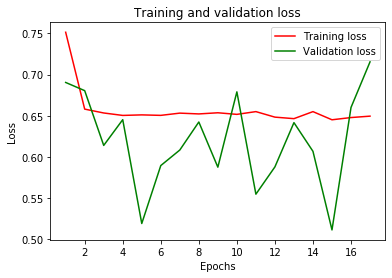

In [68]:
# Plot of Training vs Validation Loss
history_dict = history.history
print(history_dict.keys())
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(history_dict['accuracy']) + 1)
plt.plot(epochs, loss_values, 'r', label='Training loss')
plt.plot(epochs, val_loss_values, 'g', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

dict_keys(['val_loss', 'val_accuracy', 'val_precision_2', 'val_recall_2', 'loss', 'accuracy', 'precision_2', 'recall_2'])


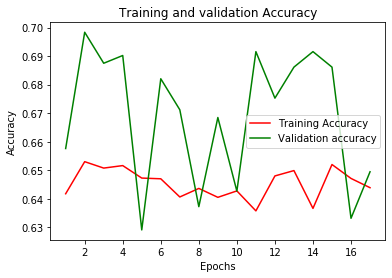

In [69]:
# Plot of Training vs Validation Accuracy
hist_dict = history.history
print(history_dict.keys())
accuracy_values = history_dict['accuracy']
val_accuracy_values = history_dict['val_accuracy']
epochs = range(1, len(history_dict['accuracy']) + 1)
plt.plot(epochs, accuracy_values, 'r', label='Training Accuracy')
plt.plot(epochs, val_accuracy_values, 'g', label='Validation accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [70]:
evaluate = model.evaluate_generator(ts_dg, steps=32, verbose=1,callbacks=None)

32/32 [==============================] - 4s 110ms/step


In [71]:
print('Accuracy: {:0.3f}'.format(evaluate [1]))

Accuracy: 0.663


In [72]:
print('Precision: {:0.3f}'.format(evaluate [2]))

Precision: 0.663


In [73]:
print('Recall: {:0.3f}'.format(evaluate [3]))

Recall: 1.000
